In [6]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import datetime
import os.path
import sys
import backtrader as bt
# 使用akshare数据源进行bt回测
import akshare as ak
import quantstats as qs

df = ak.stock_zh_a_daily(symbol="sz000001", adjust="qfq")
df1 = df.iloc[:, :5]
df1['openinterset'] = df1['close'].pct_change()
#df1.head()
# df['openinterest'].head()
#df1.to_csv('F:\\exercise\\venv\\000001.csv')
#from __future__ import (absolute_import, division, print_function,unicode_literals)

from collections import OrderedDict
from backtrader import Analyzer

#方法二
class TotalValue(Analyzer):
    '''This analyzer will get total value from every next.

    Params:
    Methods:

      - get_analysis

        Returns a dictionary with returns as values and the datetime points for
        each return as keys
    '''

    params = ( )

    def start(self):
        super(TotalValue, self).start()
        self.rets = OrderedDict()

    def next(self):
        # Calculate the return
        super(TotalValue, self).next()
        self.rets[self.datas[0].datetime.datetime()] = self.strategy.broker.getvalue()

    def get_analysis(self):
        return self.rets

# 创建策略
class TestStrategy(bt.Strategy):
    params = (
        # 持仓够5个单位就卖出
        ('exitbars', 5),)

    def log(self, txt, dt=None):
        """策略的日志函数"""
        dt = dt or self.datas[0].datetime.date(0)
        print("%s,%s" % (dt.isoformat(), txt))

    def __init__(self):
        # 引用data[0]数据的收盘价数据
        self.dataclose = self.datas[0].close
        # 用于记录订单状态
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 提交给代理或者由代理接收的买卖订单，不做操作
            return
        # 检查订单是否执行完毕
        # 注意：如果没有足够资金，代理会拒绝订单
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        # 无等待处理订单
        self.order = None
    #方法一：
    # date_value_list = []
    def next(self):

        # # 获取当天日期
        # date = self.datas[0].datetime.date(0)
        #
        # # 获取当天value
        # value = self.broker.getvalue()
        #
        # # 存入列表
        # date_value_list.append((date, value))

        # 日志输出收盘价数据
        self.log('Close, %.2f' % self.dataclose[0])

        # 检查是否有订单等待处理，如果是就不在再进行其他下单
        if self.order:
            return
            # 检查是否已经进场
        if not self.position:
            # 还未进程，则只能进行买入
            # 当日收盘价小于前一日收盘价
            if self.dataclose[0] < self.dataclose[-1]:
                # 前一日收盘价小于前前日收盘价
                if self.dataclose[-1] < self.dataclose[-2]:
                    # 买
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    # 记录订单避免二次下单
                    self.order = self.buy()
        # 如果已经在场内，则可以进行卖出操作
        else:
            # 卖
            if len(self) >= (self.bar_executed + self.params.exitbars):
                self.log('SELL CREATE , %.2f' % self.dataclose[0])
                # 记录订单，避免二次下单
                self.order = self.sell()


# 创建cerebro实体
cerebro = bt.Cerebro()
# 添加策略
cerebro.addstrategy(TestStrategy)
# 先找到脚本的位置，然后根据脚本与数据的相对路径关系找到数据位置
# 这样脚本从任意地方被调用，都可以正确地访问数据
# modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# print(modpath)
#datapath = os.path.join(modpath, '000001.csv')
datapath = '000001.csv'
# 创建价格数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2010, 10, 1),
    todate=datetime.datetime(2021, 2, 4),
    nullvalue=0.0,
    dtformat=("%Y-%m-%d"),
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    openinterset=-1
)
# 在Cerebro中添加价格数据
cerebro.adddata(data)
# 设置自动资金
cerebro.broker.setcash(1000000.0)
# 设置手续费
cerebro.broker.setcommission(commission=0.0005)
# 设置买入设置，策略，数量
cerebro.addsizer(bt.sizers.FixedSize, stake=20000)
# 打印开始信息
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# 遍历所有数据
cerebro.run(maxcpus=10)
# 打印最后结果
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
#cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
#cerebro.plot()
#qs.plots.snapshot(cerebro)
#qs.reports.html(cerebro,"SPY")
#qs.plots.snapshot(bt.analyzers.TotalValue)


Starting Portfolio Value: 1000000.00
2010-10-08,Close, 5.53
2010-10-11,Close, 5.79
2010-10-12,Close, 5.77
2010-10-13,Close, 5.95
2010-10-14,Close, 5.89
2010-10-15,Close, 6.15
2010-10-18,Close, 6.15
2010-10-19,Close, 6.28
2010-10-20,Close, 6.25
2010-10-21,Close, 6.05
2010-10-21,BUY CREATE, 6.05
2010-10-22,BUY EXECUTED, 5.95
2010-10-22,Close, 5.95
2010-10-25,Close, 6.07
2010-10-26,Close, 5.99
2010-10-27,Close, 5.96
2010-10-28,Close, 6.03
2010-10-29,Close, 5.91
2010-10-29,SELL CREATE , 5.91
2010-11-01,SELL EXECUTED, 5.94
2010-11-01,Close, 5.96
2010-11-02,Close, 5.99
2010-11-03,Close, 6.12
2010-11-04,Close, 6.07
2010-11-05,Close, 6.08
2010-11-08,Close, 6.14
2010-11-09,Close, 5.99
2010-11-10,Close, 5.82
2010-11-10,BUY CREATE, 5.82
2010-11-11,BUY EXECUTED, 5.84
2010-11-11,Close, 5.92
2010-11-12,Close, 5.52
2010-11-15,Close, 5.56
2010-11-16,Close, 5.36
2010-11-17,Close, 5.39
2010-11-18,Close, 5.52
2010-11-18,SELL CREATE , 5.52
2010-11-19,SELL EXECUTED, 5.52
2010-11-19,Close, 5.46
2010-11-22,C

In [7]:
cerebro.broker.getvalue()

1189371.4

In [15]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import datetime
import os.path
import sys
import backtrader as bt
# 使用akshare数据源进行bt回测
import akshare as ak
import quantstats as qs

df = ak.stock_zh_a_daily(symbol="sz000001", adjust="qfq")
df1 = df.iloc[:, :5]
df1['openinterset'] = df1['close'].pct_change()
df1.head()
# df['openinterest'].head()
df1.to_csv('000001.csv')
#from __future__ import (absolute_import, division, print_function,unicode_literals)

from collections import OrderedDict
from backtrader import Analyzer


#方法一：
date_value_list = []
# 创建策略
class TestStrategy(bt.Strategy):
    params = (
        # 持仓够5个单位就卖出
        ('exitbars', 5),)

    def log(self, txt, dt=None):
        """策略的日志函数"""
        dt = dt or self.datas[0].datetime.date(0)
        print("%s,%s" % (dt.isoformat(), txt))

    def __init__(self):
        # 引用data[0]数据的收盘价数据
        self.dataclose = self.datas[0].close
        # 用于记录订单状态
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 提交给代理或者由代理接收的买卖订单，不做操作
            return
        # 检查订单是否执行完毕
        # 注意：如果没有足够资金，代理会拒绝订单
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        # 无等待处理订单
        self.order = None
    #方法一：
    # date_value_list = []
    def next(self):

        # 获取当天日期
        date = self.datas[0].datetime.date(0)

        # 获取当天value
        value = self.broker.getvalue()

        # 存入列表
        date_value_list.append((date, value))

        # 日志输出收盘价数据
        self.log('Close, %.2f' % self.dataclose[0])

        # 检查是否有订单等待处理，如果是就不在再进行其他下单
        if self.order:
            return
            # 检查是否已经进场
        if not self.position:
            # 还未进程，则只能进行买入
            # 当日收盘价小于前一日收盘价
            if self.dataclose[0] < self.dataclose[-1]:
                # 前一日收盘价小于前前日收盘价
                if self.dataclose[-1] < self.dataclose[-2]:
                    # 买
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    # 记录订单避免二次下单
                    self.order = self.buy()
        # 如果已经在场内，则可以进行卖出操作
        else:
            # 卖
            if len(self) >= (self.bar_executed + self.params.exitbars):
                self.log('SELL CREATE , %.2f' % self.dataclose[0])
                # 记录订单，避免二次下单
                self.order = self.sell()


# 创建cerebro实体
cerebro = bt.Cerebro()
# 添加策略
cerebro.addstrategy(TestStrategy)
# 先找到脚本的位置，然后根据脚本与数据的相对路径关系找到数据位置
# 这样脚本从任意地方被调用，都可以正确地访问数据
# modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# datapath = os.path.join(modpath, '000001.csv')
datapath = '000001.csv'
print(datapath)
# 创建价格数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(1991, 4, 3),
    todate=datetime.datetime(2021, 2,4),
    nullvalue=0.0,
    dtformat=("%Y-%m-%d"),
    datetime=1,
    open=2,
    high=3,
    low=4,
    close=5,
    volume=6,
    openinterset=-1
)
# 在Cerebro中添加价格数据
cerebro.adddata(data)
# 设置自动资金
cerebro.broker.setcash(1000000.0)
# 设置手续费
cerebro.broker.setcommission(commission=0.0005)
# 设置买入设置，策略，数量
cerebro.addsizer(bt.sizers.FixedSize, stake=20000)
# 打印开始信息
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# 遍历所有数据
cerebro.run(maxcpus=10)
# 打印最后结果
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
#cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
#cerebro.plot()
#qs.plots.snapshot(cerebro)
#qs.reports.html(cerebro,"SPY")
#qs.plots.snapshot(bt.analyzers.TotalValue)


000001.csv
Starting Portfolio Value: 1000000.00
1991-04-03,Close, 0.40
1991-04-04,Close, 0.40
1991-04-05,Close, 0.40
1991-04-08,Close, 0.40
1991-04-09,Close, 0.39
1991-04-10,Close, 0.39
1991-04-12,Close, 0.39
1991-04-16,Close, 0.38
1991-04-17,Close, 0.38
1991-04-18,Close, 0.38
1991-04-19,Close, 0.38
1991-04-23,Close, 0.37
1991-04-24,Close, 0.37
1991-04-25,Close, 0.37
1991-04-26,Close, 0.37
1991-04-29,Close, 0.36
1991-04-30,Close, 0.36
1991-05-02,Close, 0.36
1991-05-03,Close, 0.36
1991-05-07,Close, 0.35
1991-05-08,Close, 0.35
1991-05-09,Close, 0.35
1991-05-10,Close, 0.35
1991-05-13,Close, 0.34
1991-05-14,Close, 0.34
1991-05-15,Close, 0.34
1991-05-16,Close, 0.34
1991-05-17,Close, 0.34
1991-05-20,Close, 0.33
1991-05-21,Close, 0.33
1991-05-22,Close, 0.33
1991-05-23,Close, 0.33
1991-05-24,Close, 0.33
1991-05-27,Close, 0.32
1991-05-28,Close, 0.32
1991-05-29,Close, 0.32
1991-05-30,Close, 0.32
1991-05-31,Close, 0.32
1991-06-03,Close, 0.31
1991-06-04,Close, 0.31
1991-06-06,Close, 0.31
1991-06-0

In [16]:
import numpy as np
import pandas as pd


In [17]:
dd = pd.DataFrame(date_value_list)
dd.head()

,0,1
0,1991-04-03,1000000.0
1,1991-04-04,1000000.0
2,1991-04-05,1000000.0
3,1991-04-08,1000000.0
4,1991-04-09,1000000.0


In [18]:
dd2 = dd
dd2[1] = dd2[1].pct_change()
dd2 = dd2.rename(columns={0:'date'})
dd2['date']=dd2['date'].astype('datetime64[ns]')
dd2.head()

,date,1
0,1991-04-03,NaN
1,1991-04-04,0.0
2,1991-04-05,0.0
3,1991-04-08,0.0
4,1991-04-09,0.0


In [19]:
ts = pd.Series(dd2[1].values,index = dd2['date'].values)

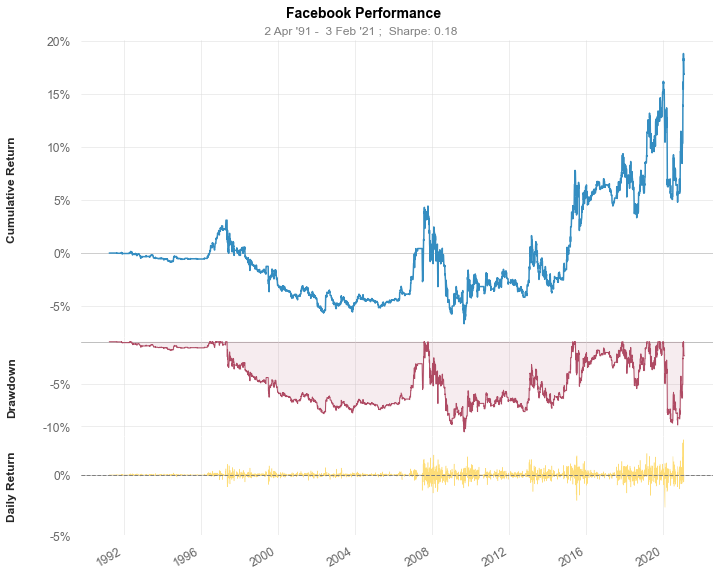

In [20]:
qs.plots.snapshot(ts, title='Facebook Performance')

In [21]:
qs.reports.html(ts,'SPY')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [22]:
qs.reports.metrics(mode='basic|full", ...) - shows basic/full metrics
qs.reports.plots(mode='basic|full", ...) - shows basic/full plots
qs.reports.basic(...) - shows basic metrics and plots
qs.reports.full(...) - shows full metrics and plots
qs.reports.html(...)- generates a complete report as html

SyntaxError: EOL while scanning string literal (<ipython-input-22-64a34b85f88c>, line 1)

In [23]:
qs.reports.metrics(ts,'SPY')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [25]:
qs.reports.metrics(ts,'basic')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [24]:
qs.reports.metrics(ts,'full')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

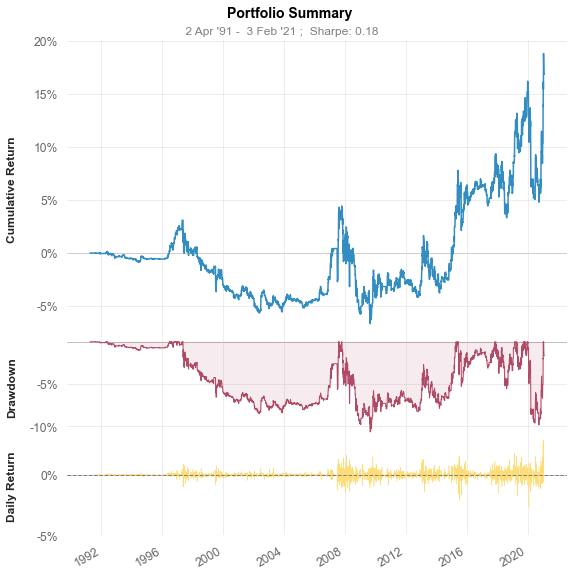

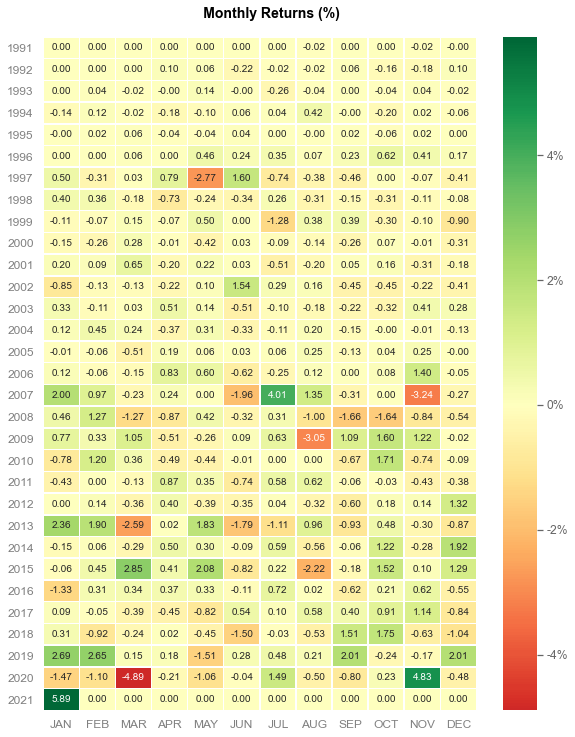

In [26]:
qs.reports.plots(ts,mode='basic')

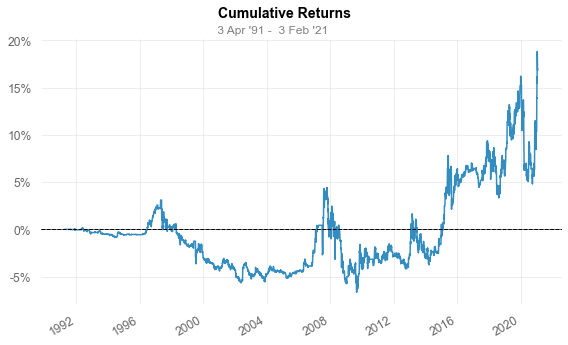

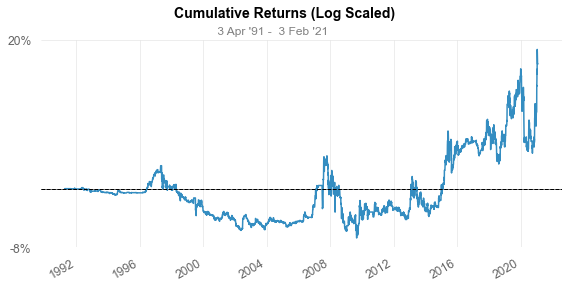

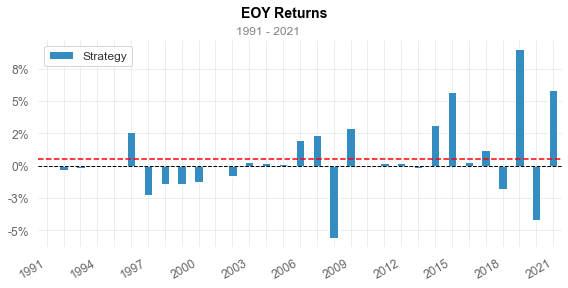

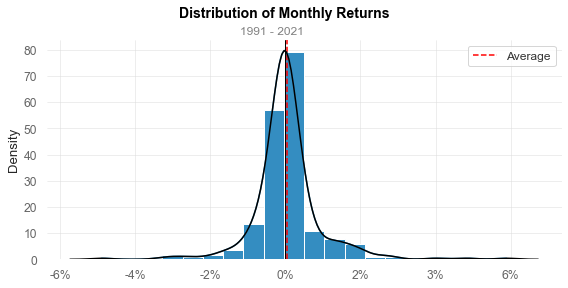

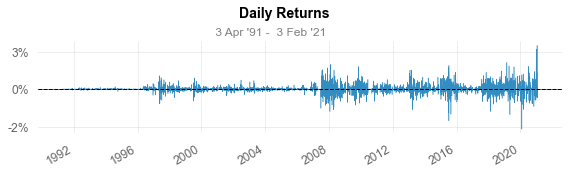

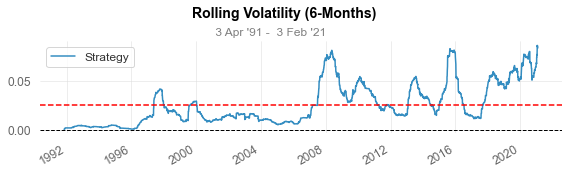

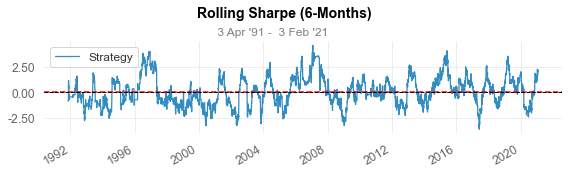

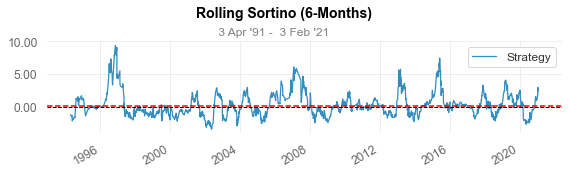

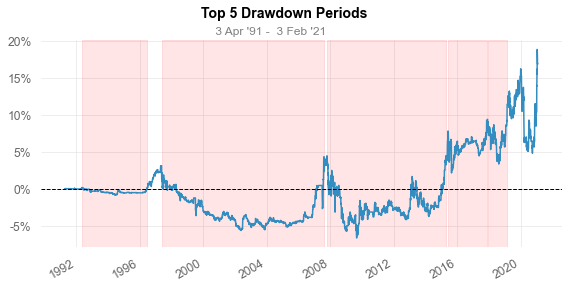

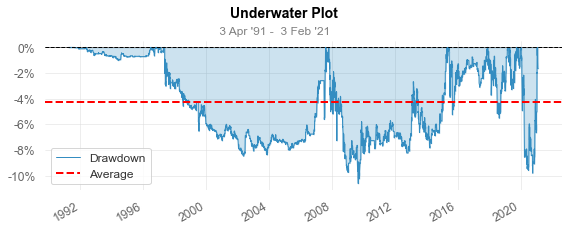

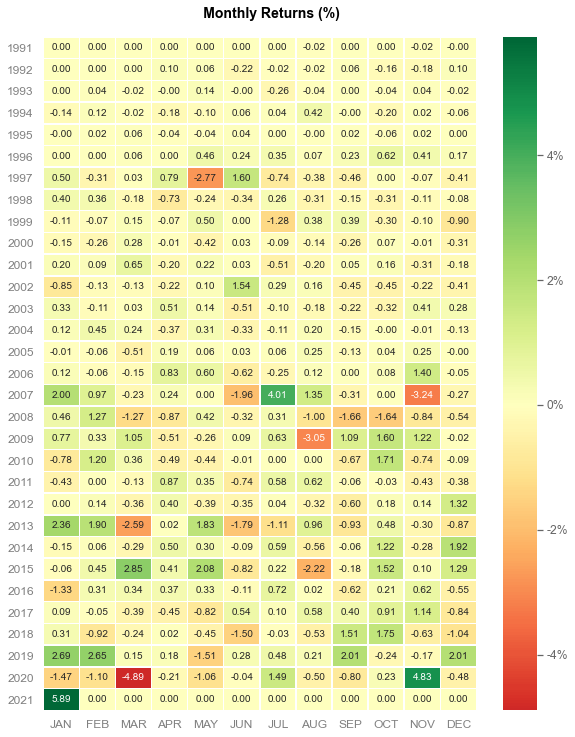

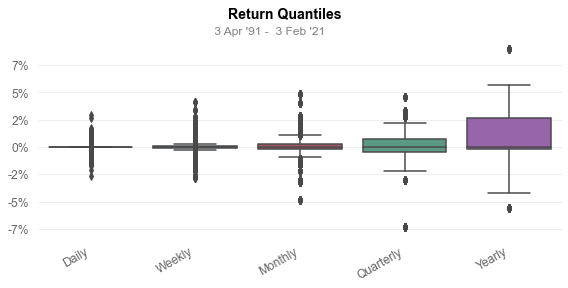

In [27]:
qs.reports.plots(ts,mode='full')

                           Strategy
-------------------------  ----------
Start Period               1991-04-03
End Period                 2021-02-03
Risk-Free Rate             0.0%
Time in Market             53.0%

Cumulative Return          16.86%
CAGR%                      0.52%

Sharpe                     0.18
Sortino                    0.26
Sortino/√2                 0.19

Max Drawdown               -10.63%
Longest DD Days            3732
Volatility (ann.)          3.41%
Calmar                     0.05
Skew                       0.45
Kurtosis                   25.59

Expected Daily %           0.0%
Expected Monthly %         0.04%
Expected Yearly %          0.5%
Kelly Criterion            2.42%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.35%
Expected Shortfall (cVaR)  -0.35%

Gain/Pain Ratio            0.06
Gain/Pain (1M)             0.21

Payoff Ratio               1.22
Profit Factor              1.06
Common Sense Ratio         1.2
CPC Index                  0.6

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-17,2009-08-31,2015-04-22,2744,-10.630921,-9.673609
2,2020-01-06,2020-09-29,2021-01-18,378,-9.814635,-9.549687
3,1997-05-14,2002-05-15,2007-08-02,3732,-8.480716,-8.349610
4,2017-11-30,2018-08-16,2019-02-22,449,-5.526978,-5.236768
5,2015-06-05,2015-08-25,2017-11-07,886,-5.259898,-4.514288


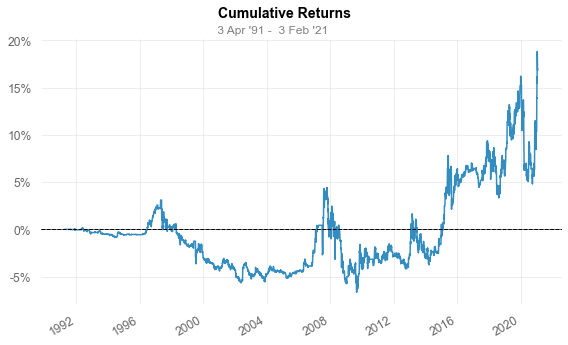

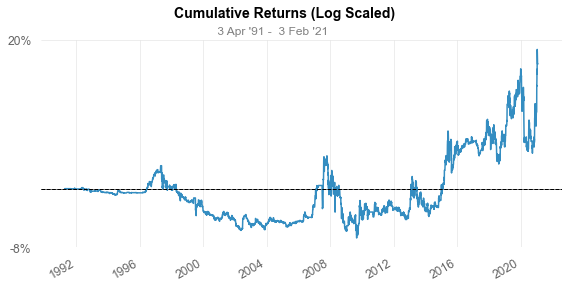

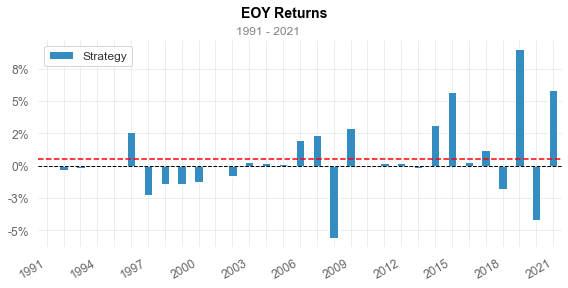

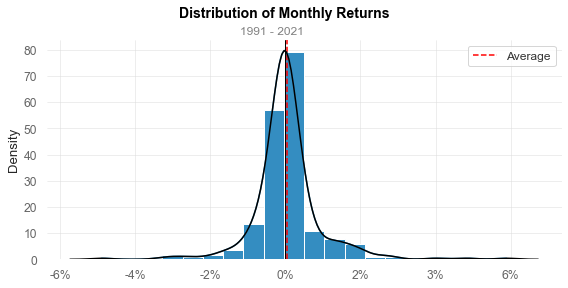

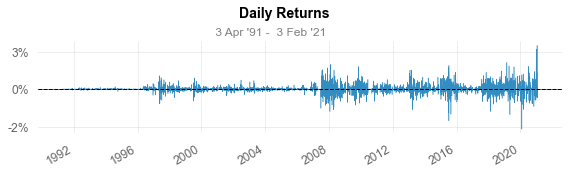

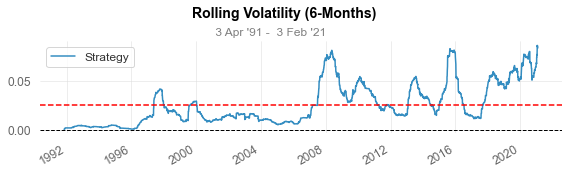

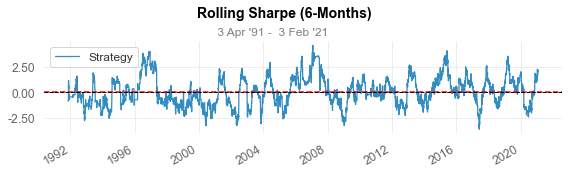

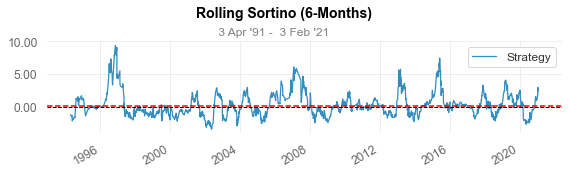

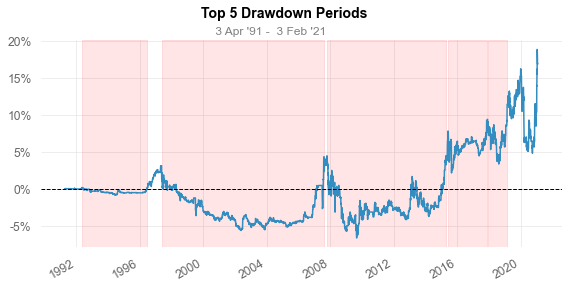

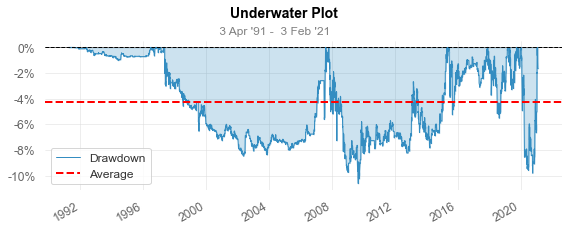

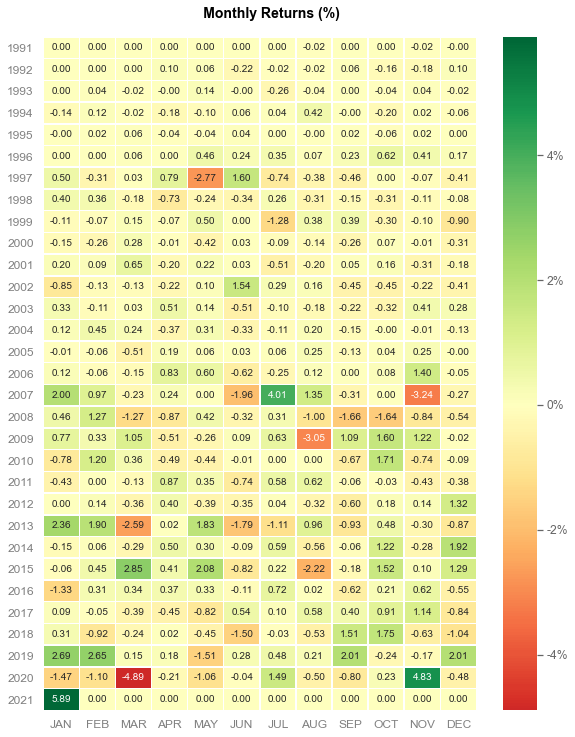

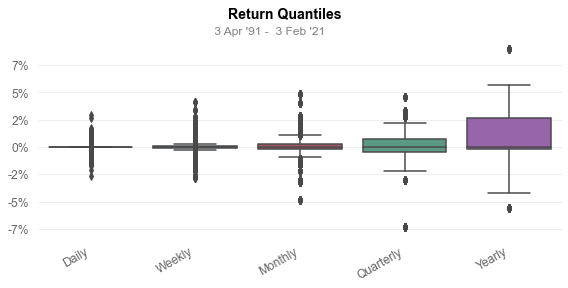

In [28]:
qs.reports.full(ts)

                    Strategy
------------------  ----------
Start Period        1991-04-03
End Period          2021-02-03
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   16.86%
CAGR%               0.52%

Sharpe              0.18
Sortino             0.26
Sortino/√2          0.19

Max Drawdown        -10.63%
Longest DD Days     3732

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.21

Payoff Ratio        1.22
Profit Factor       1.06
Common Sense Ratio  1.2
CPC Index           0.6
Tail Ratio          1.14
Outlier Win Ratio   11.19
Outlier Loss Ratio  4.61

MTD                 0.0%
3M                  10.47%
6M                  9.05%
YTD                 5.89%
1Y                  5.8%
3Y (ann.)           2.68%
5Y (ann.)           2.23%
10Y (ann.)          1.92%
All-time (ann.)     0.52%

Avg. Drawdown       -1.85%
Avg. Drawdown Days  352
Recovery Factor     1.59
Ulcer Index         inf


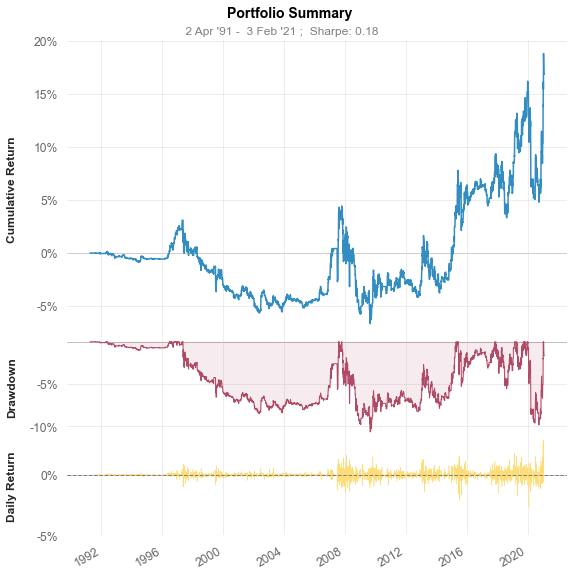

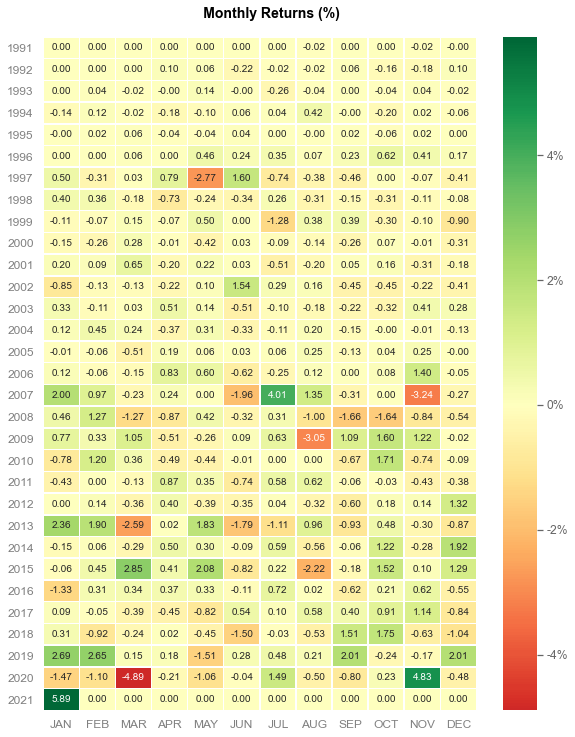

In [29]:
qs.reports.basic(ts)

In [30]:
qs.reports.html(ts,'basic')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
qs.reports.html(ts,'spy')

In [ ]:
!pip install quantstats